In [1]:
import pandas as pd 
import scanpy as sc

In [2]:
adata = sc.read_h5ad('/Volumes/Castelo_Branco/christoffer/human_ms_xenium/data/lerma_martin/spatial/merged_lerma_martin.h5ad')

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata.X.max()

3547.0

In [8]:
adata.layers['raw'] = adata.X.copy()

In [4]:
human_genes = [
    "HIF1A",     # Hypoxia inducible factor 1 alpha
    "HK2",       # Hexokinase 2
    "LDHA",      # Lactate dehydrogenase A
    "LDHB",      # Lactate dehydrogenase B
    "SLC16A1",   # Monocarboxylate transporter 1 (MCT1)
    "SLC16A3",   # Monocarboxylate transporter 4 (MCT4)
     "PDK1",      # Pyruvate dehydrogenase kinase 1
    "PFKL",      # Phosphofructokinase, liver type
    "MFN1",      # Mitofusin 1
    "MFN2",      # Mitofusin 2
    "OPA1",      # OPA1 mitochondrial dynamin like GTPase
    "PKM",       # Pyruvate kinase M1/2
    "PPARGC1A",  # PGC-1α, transcriptional coactivator
    "SIRT2",     # Sirtuin 2
    "LRIG1"
]

In [5]:
# 1) library-size normalize to 10k counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# 2) log-transform
sc.pp.log1p(adata)              # adata.X becomes log1p(CPM)


In [6]:
adata.var_names_make_unique()

In [7]:
adata

AnnData object with n_obs × n_vars = 67851 × 23049
    obs: 'array_row', 'array_col', 'patient_id', 'sample_id', 'condition', 'lesion_type', 'age', 'sex', 'rin', 'pmi_hrs', 'duration_y', 'ms_class', 'cause_death', 'batch_vs', 'areas', 'niches'
    uns: 'log1p'
    obsm: 'ccc_scores', 'ctype_abunds', 'ctype_props', 'hallmark_scores', 'progeny_scores', 'reactome_scores', 'spatial'

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


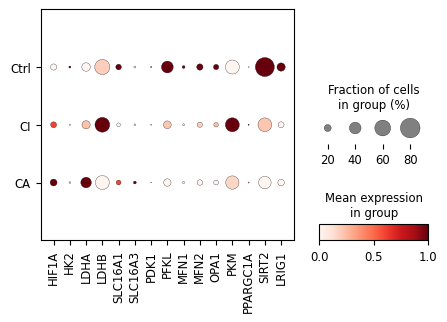

In [8]:

sc.pl.dotplot(
    adata,
    var_names=human_genes,
    groupby="lesion_type",
    standard_scale="var",
    #dot_max=0.5,
    #dot_min=0.05,
    color_map="Reds",
    dendrogram=False,
    figsize=(5, 3),
    categories_order=['Ctrl','CI', 'CA'],
    #title=cell
)


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


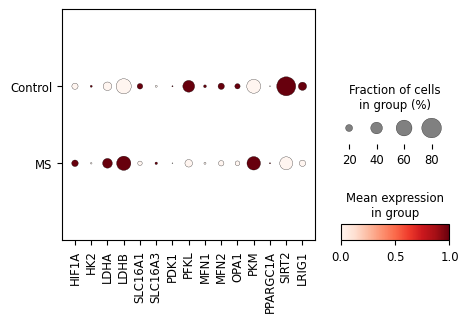

In [13]:

sc.pl.dotplot(
    adata,
    var_names=human_genes,
    groupby="condition",
    standard_scale="var",
    #dot_max=0.5,
    #dot_min=0.05,
    color_map="Reds",
    dendrogram=False,
    figsize=(5, 3),
   # categories_order=['Ctrl','CI', 'CA'],
    #title=cell
)


In [19]:
# ============================================
# Dot plot across TIMEPOINTS (single-cell)
# mean (color) + % expressing (size)
# ============================================
import numpy as np, pandas as pd
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple

# -------- helpers --------
def _to_dense(X): return X.toarray() if sp.issparse(X) else np.asarray(X)

def _get_expr_matrix(adata, layer=None):
    X = adata.layers[layer] if (layer is not None and layer in adata.layers) else adata.X
    return _to_dense(X)

def _ensure_genes_present(adata, genes):
    pres = [g for g in genes if g in adata.var_names]
    miss = [g for g in genes if g not in adata.var_*names]
    if miss: print(f"[warn] skipping {len(miss)} missing genes:", miss[:20], "..." if len(miss)>20 else "")
    return pres

# -------- summaries (per timepoint) --------
def summarize_by_time(
    adata, genes, celltype,
    time_col="timepoint",
    ct_col="cell_type",
    layer=None,
    detect_threshold=0.0,
    time_order: Optional[List[str]] = None
) -> pd.DataFrame:
    """Return tidy table with columns: cell_type, time, gene, mean, pct_expressing, n_cells."""
    genes = _ensure_genes_present(adata, genes)
    if not genes: return pd.DataFrame()

    mask = adata.obs[ct_col].astype(str).eq(celltype) & adata.obs[time_col].notna()
    sub = adata[mask, genes]
    if sub.n_obs == 0:
        print(f"[warn] no cells for {celltype}")
        return pd.DataFrame()

    X = _get_expr_matrix(sub, layer=layer)
    df = pd.DataFrame(X, index=sub.obs_names, columns=genes)
    df["time"] = sub.obs[time_col].astype(str).values

    if time_order is None:
        # keep alphanumeric order
        time_order = sorted(df["time"].unique(), key=lambda s: (len(s), s))

    rows = []
    for t in time_order:
        dt = df[df["time"] == t]
        if dt.empty: continue
        for g in genes:
            vals = dt[g].astype(float).values
            rows.append({
                "cell_type": celltype,
                "time": t,
                "gene": g,
                "mean": float(vals.mean()),
                "pct_expressing": float((vals > detect_threshold).mean()),
                "n_cells": int(len(vals))
            })
    out = pd.DataFrame(rows)
    if out.empty: return out
    out["time"] = pd.Categorical(out["time"], categories=time_order, ordered=True)
    return out.sort_values(["gene","time"])

def compute_zscores_vs_baseline(df: pd.DataFrame, baseline_time: Optional[str] = None) -> pd.DataFrame:
    """Add z-scores per gene across time; if baseline_time given, add z_vs_baseline anchored there."""
    if df.empty: return df.copy()
    out = df.copy()

    # variance across time per gene
    sd_by_gene = out.groupby(["gene"])["mean"].std(ddof=1).replace(0, np.nan)
    mean_by_gene = out.groupby(["gene"])["mean"].mean()

    out = out.join(sd_by_gene.rename("sd_gene"), on="gene")
    out = out.join(mean_by_gene.rename("mean_gene"), on="gene")

    out["z_within_gene"] = ((out["mean"] - out["mean_gene"]) / out["sd_gene"]).replace([np.inf,-np.inf], np.nan).fillna(0.0)

    if baseline_time is not None:
        base = (out.loc[out["time"].astype(str)==str(baseline_time), ["gene","mean"]]
                  .drop_duplicates("gene").rename(columns={"mean":"mean_baseline"}).set_index("gene"))
        out = out.join(base, on="gene")
        out["z_vs_baseline"] = ((out["mean"] - out["mean_baseline"]) / out["sd_gene"])\
                                 .replace([np.inf,-np.inf], np.nan).fillna(0.0)
    return out

# -------- pretty dotplot --------
def compute_log2fc_vs_baseline(
    df: pd.DataFrame,
    baseline_time: str = "Control",
    min_mean: float = 1e-6
) -> pd.DataFrame:
    """
    Compute log2 fold-change of mean expression vs baseline_time.
    
    Expects df with columns: gene, time, mean.
    Adds: log2fc_vs_baseline
    """
    if df.empty:
        return df.copy()

    out = df.copy()

    # baseline mean per gene
    ctrl_means = (
        out.loc[out["time"].astype(str) == str(baseline_time), ["gene", "mean"]]
        .drop_duplicates("gene")
        .set_index("gene")["mean"]
    )

    # join baseline to each row
    out = out.join(ctrl_means.rename("mean_baseline"), on="gene")

    # compute log2FC = log2((mean+eps)/(ctrl+eps))
    eps = min_mean
    out["log2fc_vs_baseline"] = np.log2((out["mean"] + eps) / (out["mean_baseline"] + eps))

    return out
def plot_dotplot_time(
    df: pd.DataFrame,
    title: str = "Dotplot across time",
    color_mode: str = "log1p_mean",    # add new mode below
    cmap: Optional[str] = None,
    size_range: Tuple[int,int] = (20, 300),
    sort_genes: Optional[str] = "mean",   # allow "log2fc" too
    sort_genes_time: Optional[str] = None,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
):
    if df.empty:
        print("[warn] nothing to plot"); return

    plot_df = df.copy()

    # --- COLOR SOURCE ---
    if color_mode == "log1p_mean":
        plot_df["color_val"] = np.log1p(plot_df["mean"]); cmap = cmap or "rocket_r"; cbar_label="log1p(mean)"
    elif color_mode == "mean":
        plot_df["color_val"] = plot_df["mean"]; cmap = cmap or "rocket_r"; cbar_label="mean"
    elif color_mode == "z_within_gene":
        assert "z_within_gene" in plot_df.columns, "run compute_zscores_vs_baseline first"
        plot_df["color_val"] = plot_df["z_within_gene"]; cmap = cmap or "coolwarm"; cbar_label="z (within gene)"
    elif color_mode == "z_vs_baseline":
        assert "z_vs_baseline" in plot_df.columns, "run compute_zscores_vs_baseline(..., baseline_time=...) first"
        plot_df["color_val"] = plot_df["z_vs_baseline"]; cmap = cmap or "coolwarm"; cbar_label="z vs baseline"
        if vmin is None or vmax is None:
            m = np.nanmax(np.abs(plot_df["color_val"].values)); vmin, vmax = -m, m
    elif color_mode == "log2fc_vs_baseline":
        assert "log2fc_vs_baseline" in plot_df.columns, "run compute_log2fc_vs_baseline(...) first"
        plot_df["color_val"] = plot_df["log2fc_vs_baseline"]; cmap = cmap or "coolwarm"; cbar_label="log2FC vs baseline"
        if vmin is None or vmax is None:
            m = np.nanmax(np.abs(plot_df["color_val"].values)); vmin, vmax = -m, m
    else:
        raise ValueError("bad color_mode")

    # --- GENE SORTING ---
    if sort_genes in {"mean","pct","z","log2fc"}:
        metric = {
            "mean": "mean",
            "pct": "pct_expressing",
            "z": "color_val",           # when using z-modes
            "log2fc": "log2fc_vs_baseline"
        }[sort_genes]
        if sort_genes_time is None:
            order = plot_df.groupby("gene")[metric].mean().sort_values(ascending=False).index.tolist()
        else:
            sub = plot_df.loc[plot_df["time"].astype(str) == str(sort_genes_time)]
            if sub.empty:
                order = plot_df.groupby("gene")[metric].mean().sort_values(ascending=False).index.tolist()
            else:
                order = sub.groupby("gene")[metric].mean().sort_values(ascending=False).index.tolist()
        plot_df["gene"] = pd.Categorical(plot_df["gene"], categories=order, ordered=True)
    elif sort_genes == "name":
        plot_df["gene"] = pd.Categorical(plot_df["gene"], categories=sorted(plot_df["gene"].unique()), ordered=True)

    # (rest of your plotting code unchanged) ...
    plot_df["pct_plot"] = plot_df["pct_expressing"] * 100.0
    fig_w = max(3, 0.9 * plot_df["time"].nunique())
    fig_h = 0.25 * plot_df["gene"].nunique() + 2.5
    plt.figure(figsize=(fig_w + 1.5, fig_h))
    ax = sns.scatterplot(
        data=plot_df, x="time", y="gene",
        size="pct_plot", sizes=size_range,
        hue="color_val", palette=cmap,
        edgecolor="0.25", linewidth=0.3, alpha=0.95,
        zorder=2, clip_on=False
    )
    plt.margins(x=0.2, y=0.05)
    ax.invert_yaxis(); ax.set_xlabel("Timepoint"); ax.set_ylabel(""); ax.set_title(title, weight="bold")

    norm = plt.Normalize(vmin if vmin is not None else plot_df["color_val"].min(),
                         vmax if vmax is not None else plot_df["color_val"].max())
    sm = plt.cm.ScalarMappable(cmap=sns.color_palette(cmap, as_cmap=True), norm=norm); sm.set_array([])
    cbar = ax.figure.colorbar(sm, ax=ax, pad=0.02, fraction=0.03, aspect=20); cbar.set_label(cbar_label)

    if ax.get_legend(): ax.get_legend().remove()
    def area_to_ms(a): return (a/np.pi)**0.5*2.0
    levels = (10, 50, 90)
    areas = np.interp(levels, [0, 100], list(size_range))
    handles = [plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor='none',
                          markeredgecolor='0.4', markersize=area_to_ms(a)) for a in areas]
    ax.legend(handles, [f"{p}%" for p in levels], title="% expressing",
              frameon=False, loc="upper left", bbox_to_anchor=(1.02, 1.0),
              fontsize=9, title_fontsize=10)
    ax.grid(True, axis="x", color="0.92", lw=0.7); plt.xticks(rotation=35, ha="right")
    for lab in ax.get_yticklabels(): lab.set_fontstyle("italic")
    plt.tight_layout(); plt.show()

In [20]:
def _ensure_genes_present(adata, genes):
    pres = [g for g in genes if g in adata.var_names]
    miss = [g for g in genes if g not in adata.var_names]
    if miss:
        print(f"[warn] skipping {len(miss)} missing genes: {miss[:20]}" + (" ..." if len(miss) > 20 else ""))
    return pres

In [23]:
adata.obs

,array_row,array_col,patient_id,sample_id,condition,lesion_type,age,sex,rin,pmi_hrs,duration_y,ms_class,cause_death,batch_vs,areas,niches
AAACAAGTATCTCCCA-1,50,102,CO37 P5B3,0,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,3.0,WM,WM
AAACACCAATAACTGC-1,59,19,CO37 P5B3,0,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,3.0,WM,WM
AAACAGAGCGACTCCT-1,14,94,CO37 P5B3,0,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,3.0,WM,WM
AAACAGCTTTCAGAAG-1,43,9,CO37 P5B3,0,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,3.0,WM,WM
AAACAGGGTCTATATT-1,47,13,CO37 P5B3,0,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,3.0,WM,WM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,24,64,MS549 P2D5,17,MS,CI,50,M,8.0,8.0,29.0,SPMS,MS,1.0,LC,LC
TTGTTGTGTGTCAAGA-1,31,77,MS549 P2D5,17,MS,CI,50,M,8.0,8.0,29.0,SPMS,MS,1.0,LC,LR
TTGTTTCACATCCAGG-1,58,42,MS549 P2D5,17,MS,CI,50,M,8.0,8.0,29.0,SPMS,MS,1.0,LC,LC
TTGTTTCATTAGTCTA-1,60,30,MS549 P2D5,17,MS,CI,50,M,8.0,8.0,29.0,SPMS,MS,1.0,LC,LC


In [112]:
# 1) pick genes (human symbols)
human_genes = [
    "HIF1A","HK2","LDHA","LDHB","MFN1","MFN2","OPA1","PDK1",
    "PFKL","PKM","PPARGC1A","SERPINA3","SIRT2","SLC16A1","SLC16A3"
]


In [10]:
adata.obs

,array_row,array_col,patient_id,sample_id,condition,lesion_type,age,sex,rin,pmi_hrs,duration_y,ms_class,cause_death,batch_vs,areas,niches
AAACAAGTATCTCCCA-1,50,102,CO37 P5B3,0,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,3.0,WM,WM
AAACACCAATAACTGC-1,59,19,CO37 P5B3,0,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,3.0,WM,WM
AAACAGAGCGACTCCT-1,14,94,CO37 P5B3,0,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,3.0,WM,WM
AAACAGCTTTCAGAAG-1,43,9,CO37 P5B3,0,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,3.0,WM,WM
AAACAGGGTCTATATT-1,47,13,CO37 P5B3,0,Control,Ctrl,87,M,6.1,5.0,NaN,NaN,Bladder cancer;Pneumonia,3.0,WM,WM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,24,64,MS549 P2D5,17,MS,CI,50,M,8.0,8.0,29.0,SPMS,MS,1.0,LC,LC
TTGTTGTGTGTCAAGA-1,31,77,MS549 P2D5,17,MS,CI,50,M,8.0,8.0,29.0,SPMS,MS,1.0,LC,LR
TTGTTTCACATCCAGG-1,58,42,MS549 P2D5,17,MS,CI,50,M,8.0,8.0,29.0,SPMS,MS,1.0,LC,LC
TTGTTTCATTAGTCTA-1,60,30,MS549 P2D5,17,MS,CI,50,M,8.0,8.0,29.0,SPMS,MS,1.0,LC,LC


In [ ]:
import os

outdir = "../data/zscore_results/"
dataset = 'LermaMartin'
os.makedirs(outdir, exist_ok=True)

for cell in ['Astrocytes', 'Oligodendrocytes', 'Microglia']:

    # 2) summarize within one cell type across stages
    tbl = summarize_by_time(
        adata, human_genes, celltype=cell,
        time_col="diagnosis",         
        ct_col="type_broad",         
        layer="raw",                 
        detect_threshold=0.0,
        time_order=["CTR","RRMS","SPMS","PPMS"]
    )
    
    # 3) add z-scores anchored at Control
    tblz = compute_zscores_vs_baseline(tbl, baseline_time="CTR")

    # ---- SAVE each table ----
    outfile = os.path.join(outdir, f"{cell.replace(' ','_')}_zscore.csv")
    tblz.to_csv(outfile, index=False)
    print(f"Saved {outfile}")

    # 4) plot z vs baseline
    plot_dotplot_time(
        tblz,
        title=cell+": metabolic gene activity across MS stages (z vs Control)",
        color_mode="z_vs_baseline",
        sort_genes="z",
        sort_genes_time="PPMS"
    )

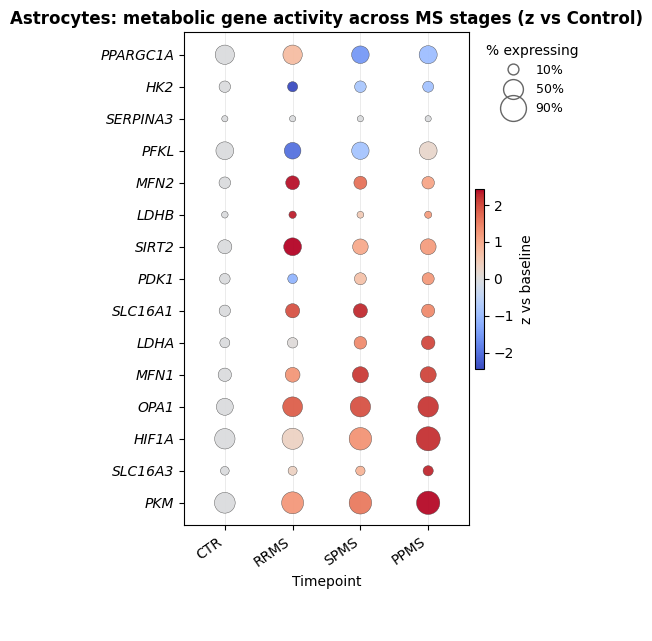

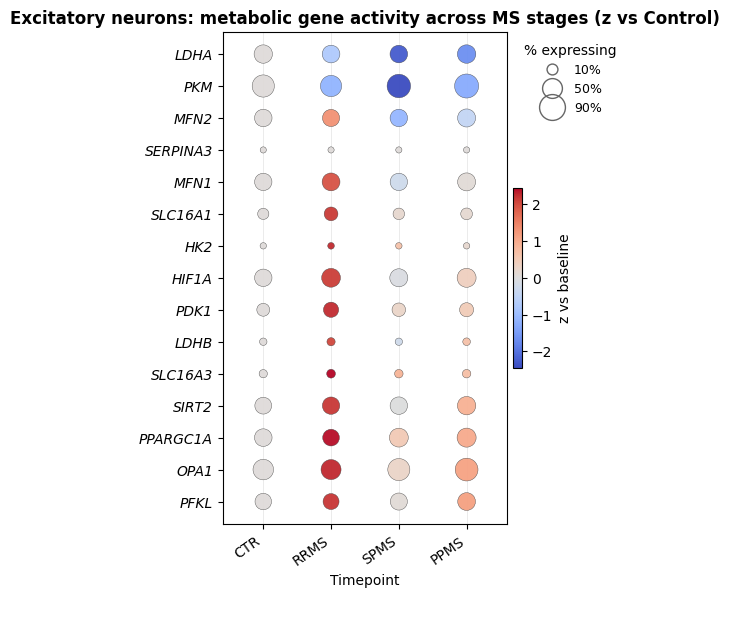

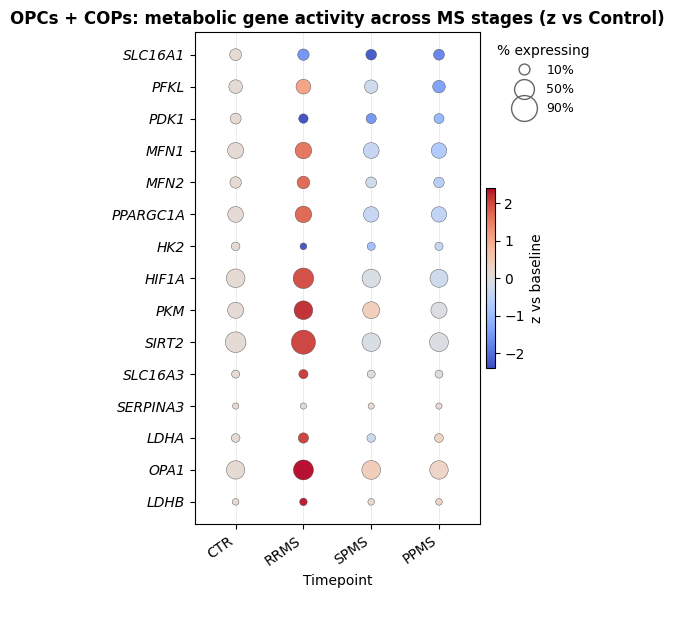

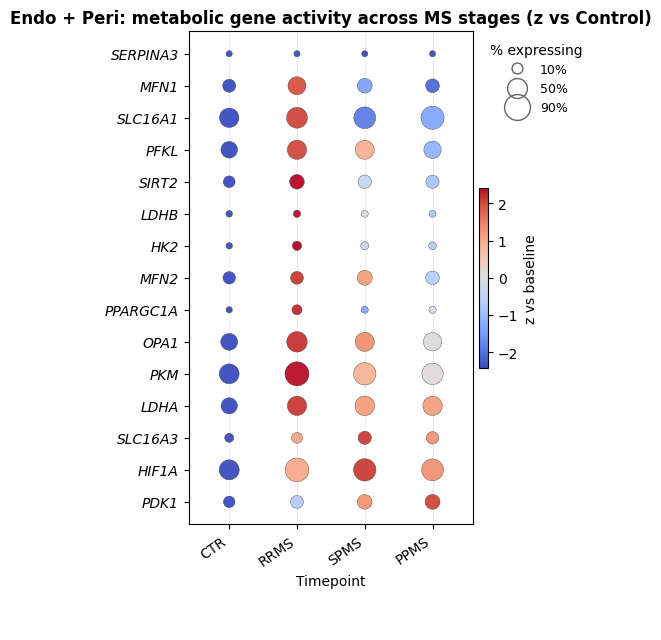

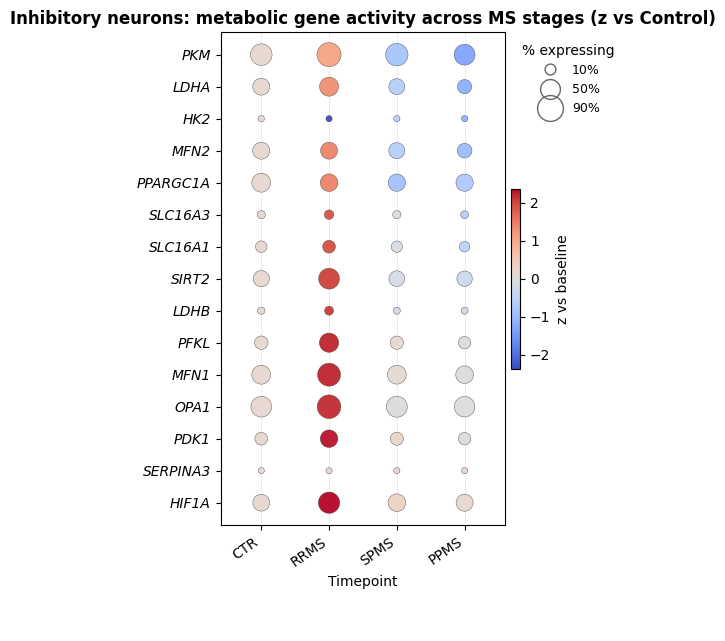

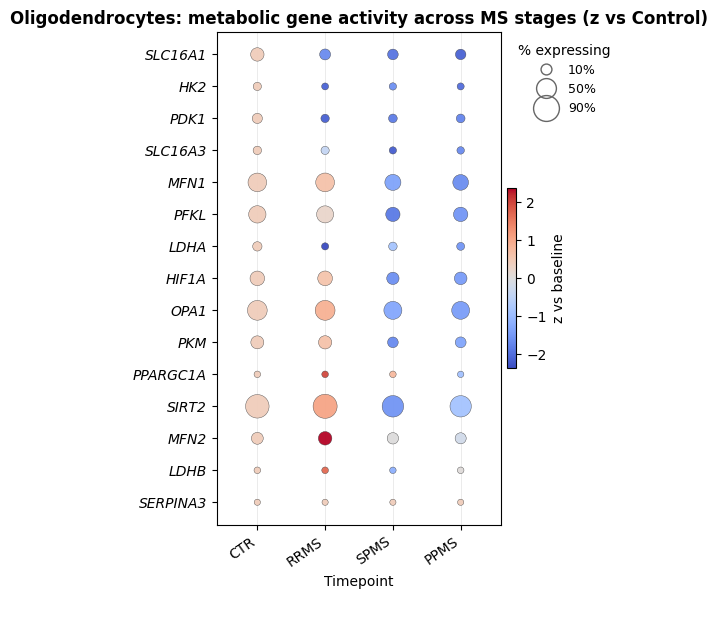

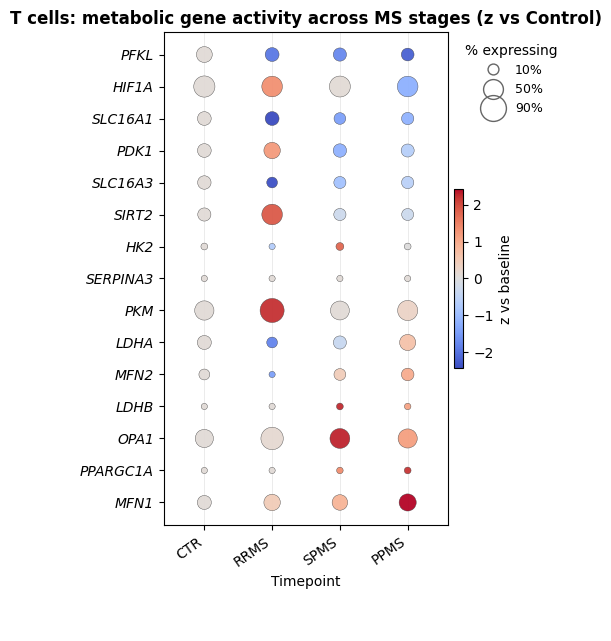

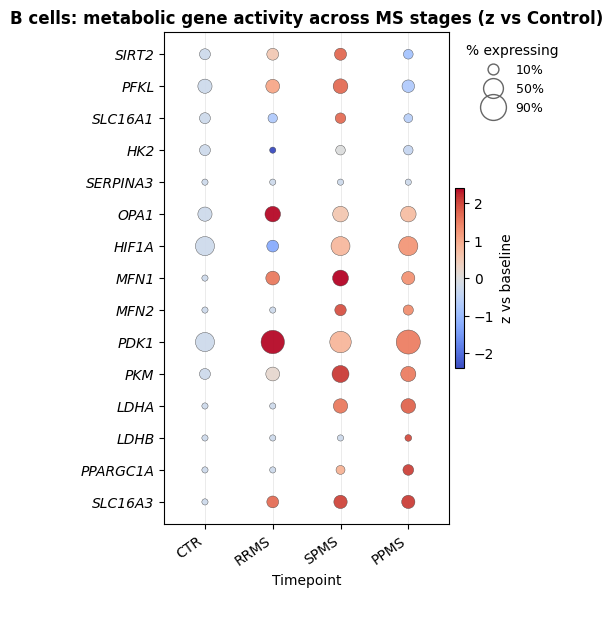

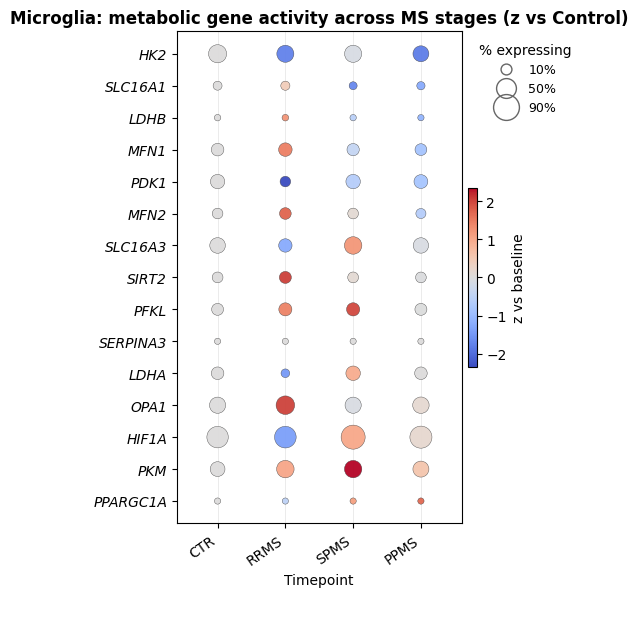

In [113]:
for cell in ['Astrocytes', 'Excitatory neurons', 'OPCs + COPs', 'Endo + Peri', 'Inhibitory neurons', 'Oligodendrocytes', 'T cells', 'B cells', 'Microglia']:
    # 2) summarize within one cell type across stages
    tbl = summarize_by_time(
        adata, human_genes, celltype=cell,   # <-- set to your label in adata.obs
        time_col="diagnosis",                            # e.g. "Control","Chronic inactive","Acute/Chronic active"
        ct_col="type_broad",                           # change if your column is different
        layer='raw',                                  # or "raw"/your layer name
        detect_threshold=0.0,
        time_order=['CTR','RRMS','SPMS', 'PPMS']
    )
    
    # 3) add z-scores anchored at Control
    tblz = compute_zscores_vs_baseline(tbl, baseline_time="CTR")
    
    # 4) plot z vs baseline (red=high, blue=low)
    plot_dotplot_time(
        tblz,
        title=cell+": metabolic gene activity across MS stages (z vs Control)",
        color_mode="z_vs_baseline",
        sort_genes="z",                 # rank genes by z in the chosen time
        sort_genes_time="PPMS"
    )

In [106]:
tblz[tblz.gene == 'SLC16A3']

,cell_type,time,gene,mean,pct_expressing,n_cells,sd_gene,mean_gene,z_within_gene,mean_baseline,z_vs_baseline
14,Astrocytes,CTR,SLC16A3,0.036753,0.033709,8870,0.014337,0.049242,-0.871104,0.036753,0.000000
29,Astrocytes,RRMS,SLC16A3,0.041833,0.037849,502,0.014337,0.049242,-0.516798,0.036753,0.354305
44,Astrocytes,SPMS,SLC16A3,0.048998,0.043752,43655,0.014337,0.049242,-0.017021,0.036753,0.854083
59,Astrocytes,PPMS,SLC16A3,0.069384,0.058709,22671,0.014337,0.049242,1.404923,0.036753,2.276027


In [107]:
tblz[tblz.gene == 'SLC16A1']

,cell_type,time,gene,mean,pct_expressing,n_cells,sd_gene,mean_gene,z_within_gene,mean_baseline,z_vs_baseline
13,Astrocytes,CTR,SLC16A1,0.101466,0.081172,8870,0.063207,0.189856,-1.398414,0.101466,0.000000
28,Astrocytes,RRMS,SLC16A1,0.225100,0.145418,502,0.063207,0.189856,0.557595,0.101466,1.956009
43,Astrocytes,SPMS,SLC16A1,0.243981,0.142939,43655,0.063207,0.189856,0.856321,0.101466,2.254735
58,Astrocytes,PPMS,SLC16A1,0.188876,0.120109,22671,0.063207,0.189856,-0.015502,0.101466,1.382911


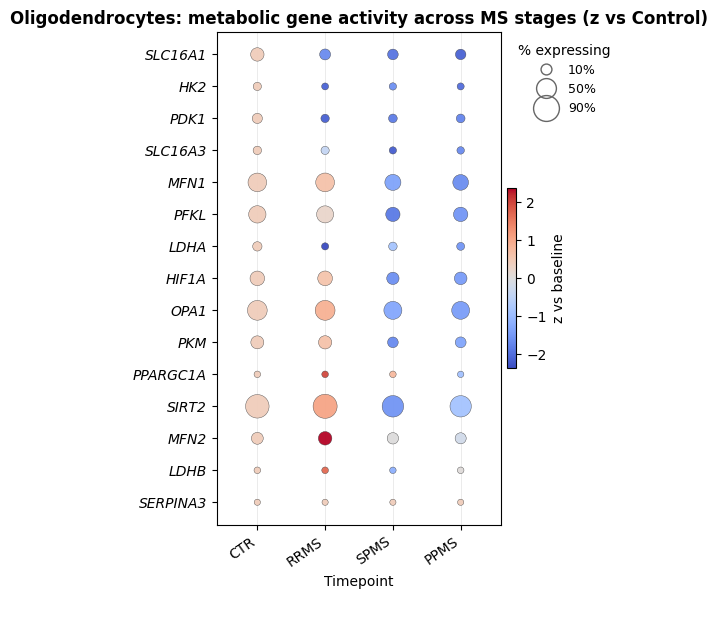

In [109]:
cell = 'Oligodendrocytes'
# Summarize
# 2) summarize within one cell type across stages
tbl = summarize_by_time(
    adata, human_genes, celltype=cell,   # <-- set to your label in adata.obs
    time_col="diagnosis",                            # e.g. "Control","Chronic inactive","Acute/Chronic active"
    ct_col="type_broad",                           # change if your column is different
    layer='raw',                                  # or "raw"/your layer name
    detect_threshold=0.0,
    time_order=['CTR','RRMS','SPMS', 'PPMS']
)

# 3) add z-scores anchored at Control
tblz = compute_zscores_vs_baseline(tbl, baseline_time="CTR")

# 4) plot z vs baseline (red=high, blue=low)
plot_dotplot_time(
    tblz,
    title=cell+": metabolic gene activity across MS stages (z vs Control)",
    color_mode="z_vs_baseline",
    sort_genes="z",                 # rank genes by z in the chosen time
    sort_genes_time="PPMS"
)

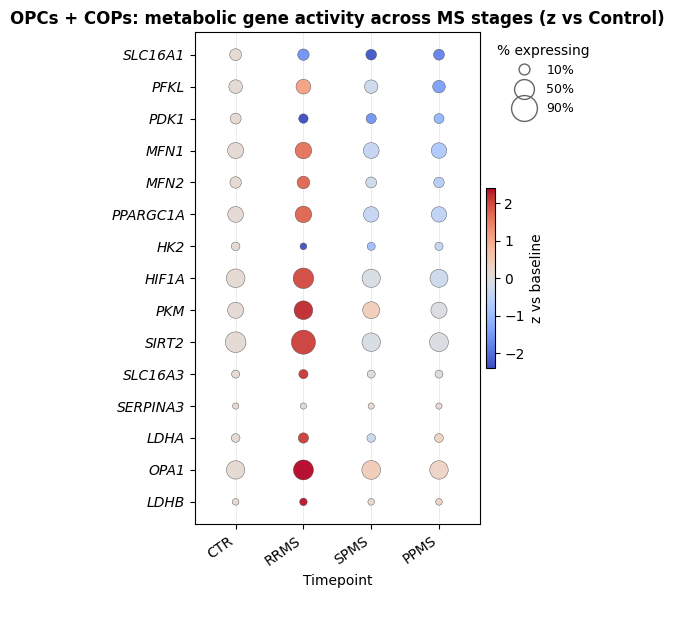

In [110]:
cell = 'OPCs + COPs'
# Summarize
# 2) summarize within one cell type across stages
tbl = summarize_by_time(
    adata, human_genes, celltype=cell,   # <-- set to your label in adata.obs
    time_col="diagnosis",                            # e.g. "Control","Chronic inactive","Acute/Chronic active"
    ct_col="type_broad",                           # change if your column is different
    layer='raw',                                  # or "raw"/your layer name
    detect_threshold=0.0,
    time_order=['CTR','RRMS','SPMS', 'PPMS']
)

# 3) add z-scores anchored at Control
tblz = compute_zscores_vs_baseline(tbl, baseline_time="CTR")

# 4) plot z vs baseline (red=high, blue=low)
plot_dotplot_time(
    tblz,
    title=cell+": metabolic gene activity across MS stages (z vs Control)",
    color_mode="z_vs_baseline",
    sort_genes="z",                 # rank genes by z in the chosen time
    sort_genes_time="PPMS"
)

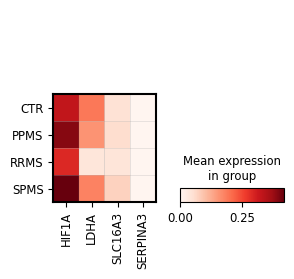

In [92]:
sc.pl.matrixplot(
    adata,
    var_names=["HIF1A","LDHA","SLC16A3",'SERPINA3'],
    groupby="diagnosis",
    use_raw=False,
    cmap="Reds"
)

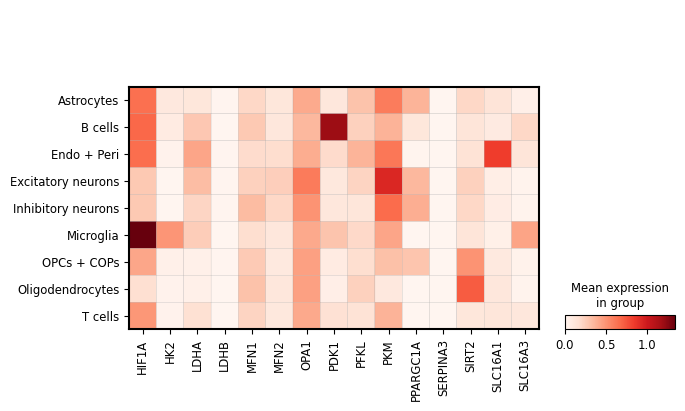

In [94]:
sc.pl.matrixplot(
    adata,
    var_names=human_genes,
    groupby="type_broad",
    use_raw=False,
    cmap="Reds",

)

In [95]:
import numpy as np
import pandas as pd

def gene_stats_by_celltype(adata, genes, celltype, ct_col="cellType", layer=None):
    """
    Compute mean and max expression for a list of genes within one cell type.
    """
    if isinstance(genes, str):
        genes = [genes]

    genes = [g for g in genes if g in adata.var_names]
    if not genes:
        raise ValueError("None of the genes are in adata.var_names")

    mask = adata.obs[ct_col].astype(str).eq(celltype)
    sub = adata[mask, genes]
    if sub.n_obs == 0:
        raise ValueError(f"No cells found for cell type {celltype}")

    X = sub.layers[layer] if (layer is not None and layer in sub.layers) else sub.X
    if not isinstance(X, np.ndarray):
        X = X.toarray()

    stats = []
    for i, g in enumerate(genes):
        vals = X[:, i]
        stats.append({
            "celltype": celltype,
            "gene": g,
            "mean": float(np.mean(vals)),
            "max": float(np.max(vals))
        })
    return pd.DataFrame(stats)

# Example:
df = gene_stats_by_celltype(adata, human_genes, celltype="Astrocytes", ct_col="type_broad")
print(df)

      celltype      gene      mean       max
0   Astrocytes     HIF1A  0.646780  4.607450
1   Astrocytes       HK2  0.100396  4.200074
2   Astrocytes      LDHA  0.117219  3.973781
3   Astrocytes      LDHB  0.007283  3.313825
4   Astrocytes      MFN1  0.204611  3.544242
5   Astrocytes      MFN2  0.116609  3.701936
6   Astrocytes      OPA1  0.404977  3.993270
7   Astrocytes      PDK1  0.110066  4.094296
8   Astrocytes      PFKL  0.300009  3.713572
9   Astrocytes       PKM  0.596784  3.949970
10  Astrocytes  PPARGC1A  0.361806  5.434319
11  Astrocytes  SERPINA3  0.000000  0.000000
12  Astrocytes     SIRT2  0.206610  3.915623
13  Astrocytes   SLC16A1  0.137770  4.037698
14  Astrocytes   SLC16A3  0.047357  3.222724


In [96]:
# Example:
df = gene_stats_by_celltype(adata, human_genes, celltype="Oligodendrocytes", ct_col="type_broad")
print(df)

            celltype      gene      mean       max
0   Oligodendrocytes     HIF1A  0.168187  3.980418
1   Oligodendrocytes       HK2  0.022827  3.482341
2   Oligodendrocytes      LDHA  0.041196  3.592800
3   Oligodendrocytes      LDHB  0.004473  3.035048
4   Oligodendrocytes      MFN1  0.308265  4.091399
5   Oligodendrocytes      MFN2  0.113273  3.640365
6   Oligodendrocytes      OPA1  0.447444  4.122252
7   Oligodendrocytes      PDK1  0.054302  4.335680
8   Oligodendrocytes      PFKL  0.239653  4.018989
9   Oligodendrocytes       PKM  0.100718  3.800684
10  Oligodendrocytes  PPARGC1A  0.005047  4.330733
11  Oligodendrocytes  SERPINA3  0.000000  0.000000
12  Oligodendrocytes     SIRT2  0.720590  4.118775
13  Oligodendrocytes   SLC16A1  0.110682  3.393736
14  Oligodendrocytes   SLC16A3  0.019586  3.178677


In [97]:
# Example:
df = gene_stats_by_celltype(adata, human_genes, celltype="T cells", ct_col="type_broad")
print(df)

   celltype      gene      mean       max
0   T cells     HIF1A  0.483999  3.870125
1   T cells       HK2  0.021566  2.745812
2   T cells      LDHA  0.162537  3.126168
3   T cells      LDHB  0.004762  2.286632
4   T cells      MFN1  0.224151  3.226201
5   T cells      MFN2  0.106853  2.953963
6   T cells      OPA1  0.408793  3.492637
7   T cells      PDK1  0.157171  3.318516
8   T cells      PFKL  0.148437  3.062800
9   T cells       PKM  0.367616  3.096452
10  T cells  PPARGC1A  0.004369  1.711118
11  T cells  SERPINA3  0.000000  0.000000
12  T cells     SIRT2  0.120256  3.197619
13  T cells   SLC16A1  0.125522  3.352924
14  T cells   SLC16A3  0.113709  2.794899


In [75]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

def gene_stats_grouped(
    adata,
    genes,
    group_cols=("cellType",),   # e.g. ("cellType",) or ("cellType","diagnosis")
    layer=None,
    detect_threshold=None        # set e.g. 0.0 to also return pct_expressing
):
    """
    Returns a tidy DataFrame with columns:
      group_1, [group_2, ...], gene, mean, max, [pct_expressing]
    """
    if isinstance(genes, str):
        genes = [genes]
    genes = [g for g in genes if g in adata.var_names]
    if not genes:
        raise ValueError("None of the requested genes are in adata.var_names.")

    # subset matrix once for speed
    X_full = adata.layers[layer] if (layer and layer in adata.layers) else adata.X
    X_full = X_full.tocsr() if sp.issparse(X_full) else np.asarray(X_full)

    meta = adata.obs[list(group_cols)].astype(str).copy()
    rows = []

    # Precompute column indices for genes
    gene_idx = {g: adata.var_names.get_loc(g) for g in genes}

    for grp_vals, idx in meta.groupby(list(group_cols)).groups.items():
        if not isinstance(grp_vals, tuple):
            grp_vals = (grp_vals,)
        # slice rows (cells in this group)
        Xi = X_full[idx, :] if sp.issparse(X_full) else X_full[np.array(list(idx)), :]

        for g in genes:
            col = gene_idx[g]
            vals = Xi[:, col].toarray().ravel() if sp.issparse(Xi) else Xi[:, col]
            rec = {f"group_{i+1}": v for i, v in enumerate(grp_vals)}
            rec.update({
                "gene": g,
                "mean": float(np.mean(vals)),
                "max":  float(np.max(vals)),
            })
            if detect_threshold is not None:
                rec["pct_expressing"] = float((vals > detect_threshold).mean())
            rows.append(rec)

    return pd.DataFrame(rows)